(compose_own_plot)=
# Create your own figure with `PlotCollection`

:::{warning} work in progress
:::

This tutorial covers how to use `PlotCollection` to simplify the creation of bespoke visualizations. We will cover how to create `PlotCollection` classes directly and two common strategies to fill your {term}`figure` using your `PlotCollection` instance.

## `PlotCollection` design overview
The main goal of the `PlotCollection` class is to allow you to write plotting functions that generate the minimal combination of artists.
You can then generate a `PlotCollection` with the {term}`faceting` strategy and {term}`aesthetic mappings` you want and apply that minimal plotting
function through {meth}`~arviz_plots.PlotCollection.map` which will subset your data and pass each subset along with its corresponding {term}`plot` and {term}`aesthetics` to
your minimal plotting function as many times as needed.

## Writing your minimal plotting function
We want a plotting function that can be used through `PlotCollection.map`. As we have mentioned, `PlotCollection` subset and ensures alignment between the data subsets, the {term}`plot` and the {term}`aesthetics`; consequently, our function will need to accept at least these 3 elements. The expected call signature of `.map` compatible functions is `fn(da, target, ..., **kwargs)`.

* `da` is a {class}`~xarray.DataArray` a subset of the input data
* `target` is the plotting backend object representing the {term}`plot` corresponding to this subset
* `**kwargs` will contain the key-value pairs for all {term}`aesthetic mappings` corresponding to this subset

Other than that, it can be a single function that adds multiple {term}`artists` at once or multiple artist specific functions or a combination of both. `arviz_plots` provides some artist specific functions in `arviz_plots.visuals`, but most bespoke visualizations will probably need something not available there.

As a first step and to facilitate quick iteration it can be better to use a monolithic function, then as the visualization solidifies and you want more fine grained control over it it can become necessary to switch to artist specific functions. Here we will use a common regression plot with 3 elements: observation xy scatter, posterior mean regression line and hdi band over the predicted distributions; and showcase the two approaches.

### Tutorial data overview

In [1]:
import arviz_base as azb
import arviz_stats as azs
import arviz_plots as azp

azp.style.use("arviz-variat")

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import xarray as xr

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# generate data ------------------------------------------------------------------------
n_groups = 4
group_size = [2, 4, 6, 8]

# Group-specific parameters
slopes = rng.normal(1, 0.2, size=n_groups)
intercepts = rng.normal(0, 1, size=n_groups)

# Generate data
data = []
for i in range(n_groups):
    n = group_size[i]
    x_vals = np.sort(rng.uniform(0, 20, size=n))
    noise = rng.normal(0, 1, size=n)
    y_vals = slopes[i] * x_vals + intercepts[i] + noise
    group_labels = np.full(n, i)
    data.append(pd.DataFrame({"x": x_vals, "y": y_vals, "group": group_labels}))

# Combine all groups into a single DataFrame
df = pd.concat(data, ignore_index=True)
df["group"] = df["group"].astype("category")

# Build a PyMC model -------------------------------------------------------------------
prior_mean = 0
prior_std = 1

x_data = df.x.values
y_data = df.y.values

coords = {"groups": df["group"].cat.categories, "obs_id": df.index}

with pm.Model(coords=coords) as model:
    x = pm.Data("x", x_data, dims="obs_id")
    y = pm.Data("y", y_data, dims="obs_id")
    group = pm.Data("group", df["group"].cat.codes.values, dims="obs_id")
    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims=["groups"])
    beta = pm.Normal("beta", mu=prior_mean, sigma=prior_std, dims=["groups"])
    sigma = pm.HalfNormal("sigma", sigma=5)
    # likelihood
    mu = pm.Deterministic("mu", intercept[group] + beta[group] * x, dims="obs_id")
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y, dims="obs_id")
    # sample
    idata = pm.sample()

# Generate a grid of points to evaluate on ---------------------------------------------
n_interp_points = 20
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_interp_points)
        for group in df.groupby("group")
    ]
)
g = np.concatenate([[i] * n_interp_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "group": g, "y": np.zeros_like(xi)}

# Posterior prediction on the grid of points -------------------------------------------
coords = {"groups": predict_at["group"], "obs_id": np.arange(len(xi))}

with model:
    pm.set_data(predict_at, coords=coords)
    idata.extend(
        pm.sample_posterior_predictive(
            idata,
            var_names=["mu"],
            random_seed=rng,
            progressbar=False,
            predictions=True,
        )
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/tmp/ipykernel_25562/176044696.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group in df.groupby("group")
Sampling: []


Our data for the tutorial is a regression model with unpooled slope and intercept; each `group` has their own regression coefficientes. Moreover, the number of observations within each group is different. Therefore, we can't have `group` as a dimension so we add that information as a coordinate variable
of `obs_id` which represents individual observations:

In [3]:
data = xr.merge((idata.constant_data, idata.observed_data)).set_coords("group")
data

<xarray.Dataset> Size: 560B
Dimensions:  (obs_id: 20)
Coordinates:
  * obs_id   (obs_id) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    group    (obs_id) int32 80B 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_id) float64 160B 2.562 9.008 4.545 8.868 ... 9.391 9.514 13.4
    obs      (obs_id) float64 160B 1.647 8.383 2.666 4.763 ... 11.06 11.86 15.82
Attributes:
    created_at:                 2025-05-20T11:57:07.008912+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

We also define a linspace over the `x` values on which to predict for a denser grid. Thus we also have a `pred_data` Dataset and a `predictions` dataset where we make sure to use the same `group` coordinate (but note that its length and contents are different than in `data`).

:::{note}
For the predictions, we use different linspaces for each group but they all have the same number of elements, so it would be possible to use {func}`~xarray_einstats.einops.rearrange` to reshape the data into `(group, obs_id)` shape. As that is not necessary to use the data with `PlotCollection` we will stick to using the extra coordinate with the group factors.
:::

In [4]:
pred_data = idata.predictions_constant_data.set_coords("group")
pred_data

<xarray.Dataset> Size: 2kB
Dimensions:  (obs_id: 80)
Coordinates:
  * obs_id   (obs_id) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_id) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_id) float64 640B 2.562 2.902 3.241 3.58 ... 12.26 12.83 13.4
Attributes:
    created_at:                 2025-05-20T11:57:07.270210+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

In [5]:
predictions = idata.predictions.assign_coords(group=pred_data["group"])
predictions

<xarray.Dataset> Size: 3MB
Dimensions:  (chain: 4, draw: 1000, obs_id: 80)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id   (obs_id) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_id) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
Data variables:
    mu       (chain, draw, obs_id) float64 3MB 0.6858 1.064 ... 15.09 15.76
Attributes:
    created_at:                 2025-05-20T11:57:07.267264+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

### Option 1: monolithic function
The first option is to write a single function that takes as many arguments as needed. In this case we will use `predictions["mu"]` to initialize the `PlotCollection` and then the constant data for the predictions and the observations will be passed as kwargs.

As indicated in its docstring, {meth}`~arviz_plots.PlotCollection.map` checks the provided kwargs before passing them to the function being called,
and subsets xarray objects if possible. That means that we can use `DataArray` and `Dataset` objects as kwargs in `.map` which will be passed to the function being called as `DataArray`. The only restriction is on `Dataset`s which if used need to have the same variables (or a subset) of those in the `data` argument.

`arviz-plots` has a lot of inspiration from grammar of graphics but it also deviates in many places to account for the specificities involved in using a `Dataset` as input instead of a `DataFrame`. This particular case deviates even more from grammar of graphics, but it will in many cases be closer to what you have been doing so far; this pattern below:

```python
fig, axes = plt.subplots(...)
for i, group in enumerate(groups):
    da = data.sel(group=group)
    ax = axes[i]
    ax.xyz(...)
    # and/or
    az.xyz(..., axes=ax)
    # repeat?
```

If using a pattern similar to this one, you should be able to copy anything after subsetting `data` and `axes` into a monolithic plotting function and use it through `PlotCollection` to easily change faceting and aesthetics without needing to modify the plotting code at all.

In [6]:
def line_band_dots(da, target, x_pred, x, y, **kwargs):
    """Add mean line, hdi band and observation xy scatter to a matplotlib plot.

    Parameters
    ----------
    da : DataArray
        Predicted samples for the regression line mean.
    target : matplotlib.axes.Axes
    x_pred : DataArray
        Independent variable used to generate the predicted samples
    obs : Dataset
        Dataset with `x` and `y` variables containing the observations
    **kwargs
        Passed downstream to matplotlib plotting functions
    """
    hdi = da.azstats.hdi()
    target.fill_between(x_pred, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), alpha=0.3, **kwargs)
    target.plot(x_pred, da.mean(dim=["chain", "draw"]), **kwargs)
    target.plot(x, y, "o", **kwargs)

### Option 2: artist specific functions
Another option, which is what {ref}`batteries-included plots <plots_intro>` do, is writing multiple functions, one for each conceptually different thing to add/do to the plot. To reproduce the example above we'd then need 3 functions: one for the scatter, one for the line and one for the band.

This approach can be harder to get started on, especially if coming from an existing plot as mentioned in the previous section, but it is much more powerful. The main advantage is that we can use different aesthetics in each of the different elements. A secondary advantage is it also allows storing the plotting backend classes representing the different artists into the `.viz` attribute and to then modify some of them afterwards if desired as shown in {ref}`use_plotcollection`.

Moreover, as this is what batteries-included plots do, there are several such functions ready to use in `arviz_plots.visuals`. That being said, the goal of the library is not to provide a comprehensive catalog of these functions, only to expose the ones available that are used somewhere else within the library.

In this particular case, we can use {func}`arviz_plots.visuals.line_xy` and {func}`arviz_plots.visuals.scatter_xy` so we'll only add an artist specific function for the HDI band.

The `line_xy` takes the data and plots a line from it we'll need to precompute the mean and use that as input so we'll do the same for the HDI. This is yet another difference with the case above, but using this pattern will prevent any recomputation evey time you want to generate a plot with this data. You'll only need to recompute if you wanted to for example change how the data is reduced. It is also worth noting that we could also do this with the monolithic function, we'd only need to add some extra kwargs to take the precomputed quantities.

In [7]:
def hdi_band(da, target, x, **kwargs):
    return target.fill_between(x, da.sel(hdi="lower"), da.sel(hdi="higher"), **kwargs)

hdi_ds = predictions.azstats.hdi()
mean_ds = predictions.mean(["chain", "draw"])

## Initializing a `PlotCollection`

The two main ways to initialize a `PlotCollection` are {meth}`~arviz_plots.PlotCollection.grid` and {meth}`~arviz_plots.PlotCollection.wrap`. The choice of classmethod defines the faceting strategy, with the specific faceting being dependent on the `cols`, `rows` and `col_wrap` arguments, and {term}`aesthetic mappings` are defined in the same way independently of the classmethod.

In this section we will use interchangeably the two approaches above to show the same results can be achieved with either approach.

### Defining the faceting
We can use `.grid` to generate column of {term}`plots` per group. If we map nothing to the rows we'll get 4 plots total, one per group:

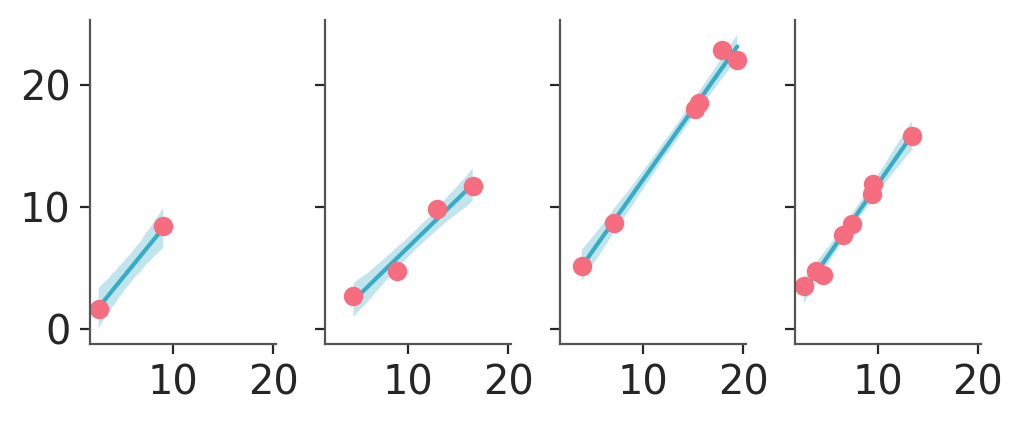

In [8]:
pc = azp.PlotCollection.grid(
    predictions,
    cols=["group"],
    plot_grid_kws={"sharex": True, "sharey": True, "figsize": (5, 2)}
)
pc.map(hdi_band, data=hdi_ds, x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=mean_ds, x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

Here there is no color aesthetics nor we are setting it manually, so the backend (matplotlib in this case) chooses to color to use.
In matplotlib, multiple calls to `.plot` _on the same axes_ get different colors from its default color cycle hence the color change
the scatter plot.

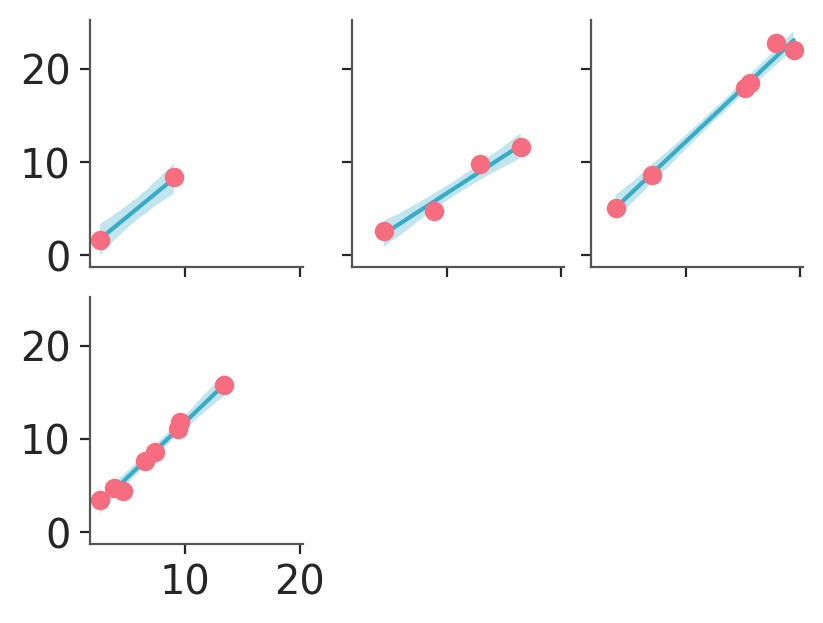

In [9]:
pc = azp.PlotCollection.wrap(
    predictions,
    cols=["group"],
    col_wrap=3,
    plot_grid_kws={"sharex": True, "sharey": True, "figsize": (4, 3)}
)
pc.map(line_band_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"])

We can also use `.grid` to generate one plot per combination of `group` and `chain` -> 16 total. In this case we'll need to not reduce the `chain` dimension when computing the mean and HDI, so we need to recompute our datasets. If we wanted to use the monolithic function in this case we'd either need to modify it or change it so `dims`/`sample_dims` becomes an argument.

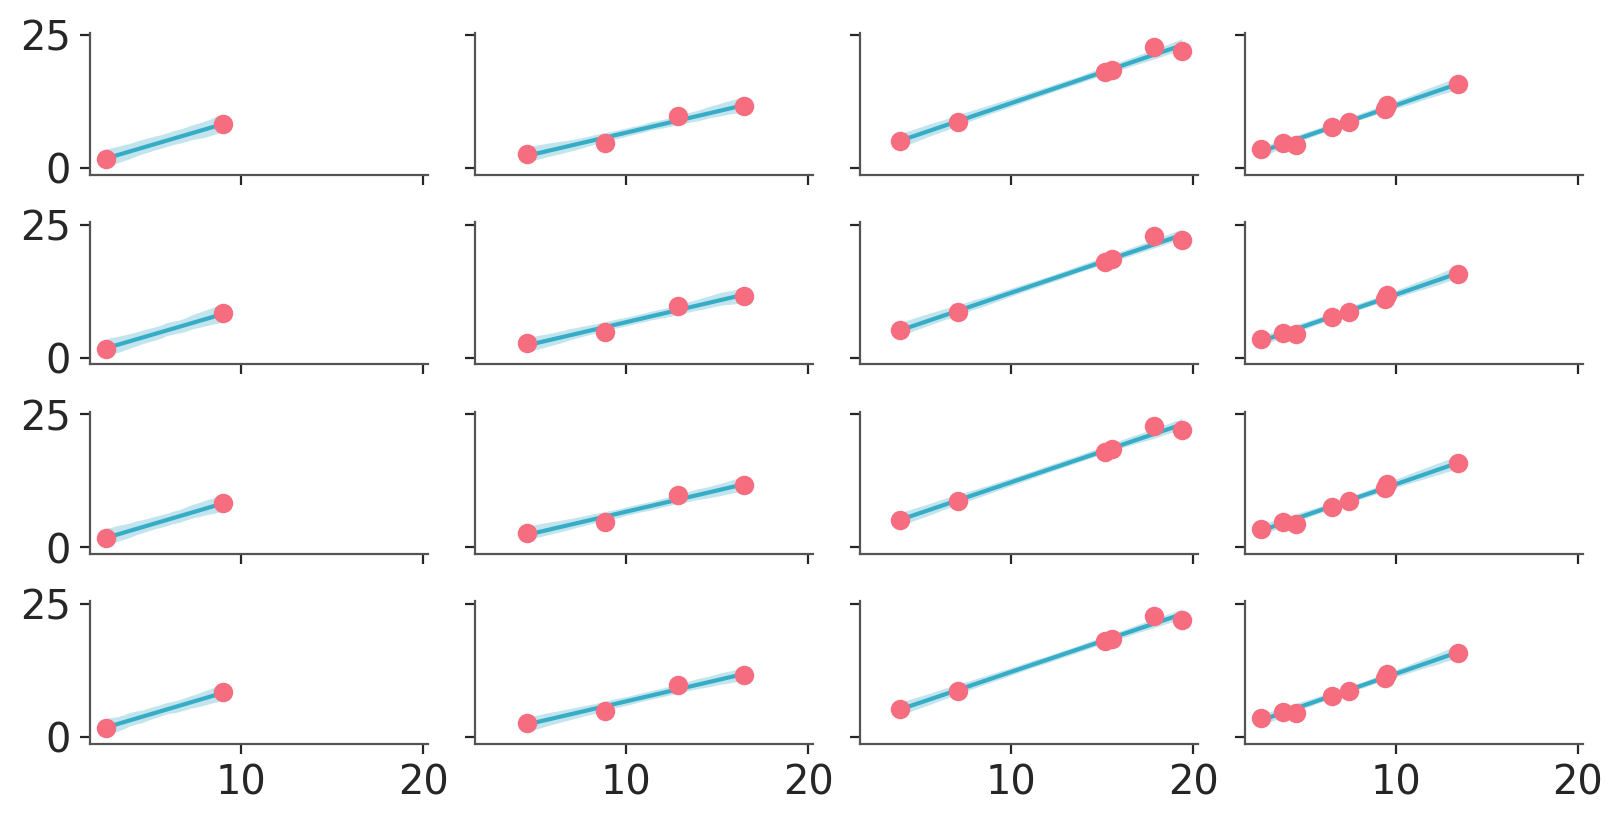

In [10]:
pc = azp.PlotCollection.grid(
    predictions,
    cols=["group"],
    rows=["chain"],
    plot_grid_kws={"sharex": True, "sharey": True, "figsize": (8, 4)}
)
# we now need hdi and mean without reducing the "chain" dimension
# so we don't use hdi_ds and mean_ds
pc.map(hdi_band, data=predictions.azstats.hdi(dims=["draw"]), x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=predictions.mean("draw"), x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

### Defining the aesthetic mappings
Aesthetic mappings are always defined via the `aes` keyword argument of the `PlotCollection` classmethods. It can be used on its own:

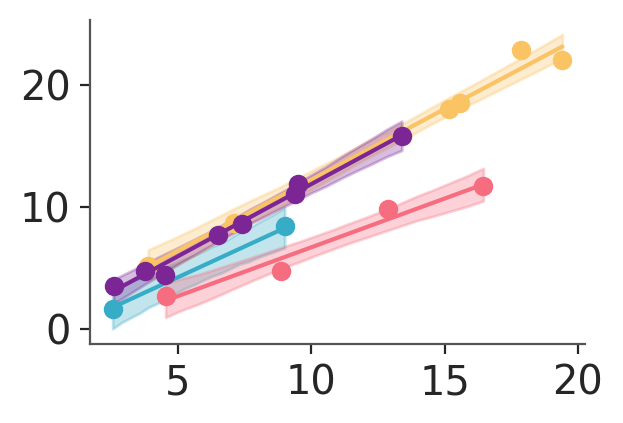

In [11]:
pc = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"]},
    plot_grid_kws={"figsize": (3, 2)}
)
pc.map(line_band_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"])

or combined with faceting:

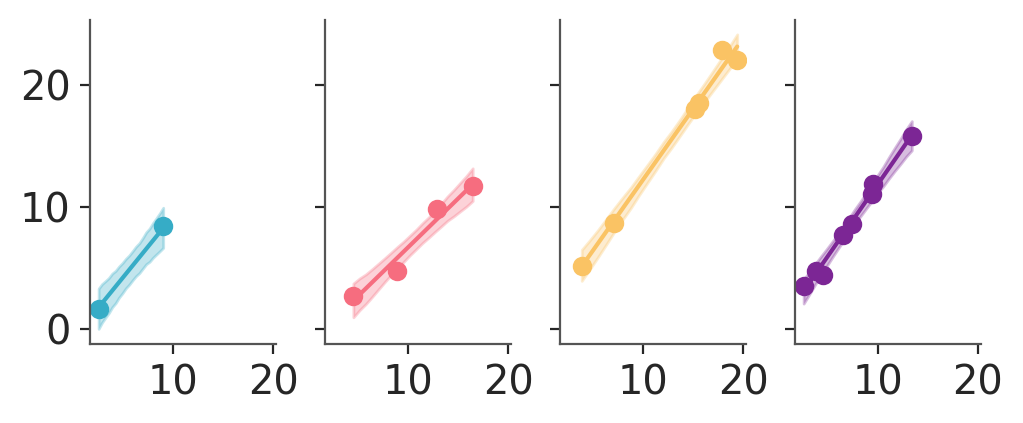

In [12]:
pc = azp.PlotCollection.grid(
    predictions[["mu"]],
    cols=["group"],
    aes={"color": ["group"]},
    plot_grid_kws={"sharex": True, "sharey": True, "figsize": (5, 2)}
)
pc.map(hdi_band, data=hdi_ds, x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=mean_ds, x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

faceting and aesthetics are independent mappings from one another:

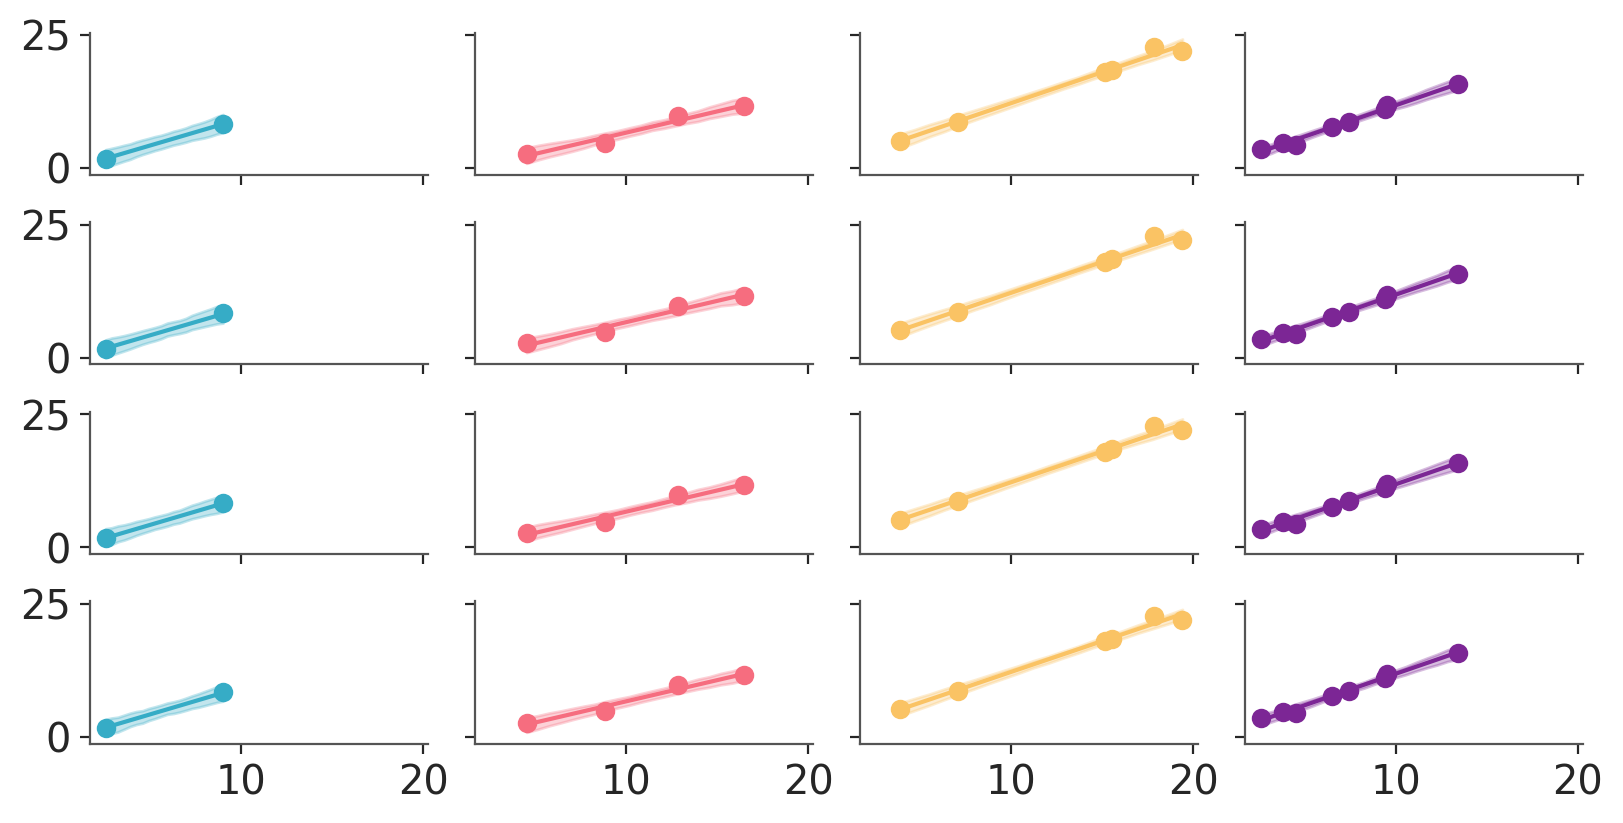

In [13]:
pc_chain = azp.PlotCollection.grid(
    predictions,
    cols=["group"],
    rows=["chain"],
    aes={"color": ["group"]},
    plot_grid_kws={"sharex": True, "sharey": True, "figsize": (8, 4)}
)
# we now need hdi and mean without reducing the "chain" dimension
# so we don't use hdi_ds and mean_ds
pc_chain.map(hdi_band, data=predictions.azstats.hdi(dims=["draw"]), x=pred_data["x"], alpha=0.3)
pc_chain.map(azp.visuals.line_xy, data=predictions.mean("draw"), x=pred_data["x"])
pc_chain.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

:::{seealso}
* coming soon: In depth explanation of how faceting and aesthetics are handled
* {ref}`add_new_plot` is a guide for contributors and developers working on batteries-included plots. If you are using `PlotCollection` to generate domain specific plots included in another library it will probably be helpful to you as it covers internal scaffolding to for example know which dimensions to reduce based on `sample_dims` input and existing aesthetic mappings.
:::